In [1]:
import numpy as np
import computing, results_annalysis
import instance_genrerantion
from scipy.optimize import dual_annealing
import time
import random
import networkx as nx
import math
import matplotlib.pyplot as plt

In [3]:
def read_graph(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()
        N, E = map(int, lines[0].split())
        graph = np.zeros((N, N))
        for line in lines[1:]:
            i, j, w = map(int, line.split())
            graph[i-1, j-1] = w
            graph[j-1, i-1] = w  # since the graph is undirected
    return np.array(graph)

In [4]:
graph = read_graph('MAX-CUT dataset/G2')

In [5]:
np.sqrt(graph.size)

800.0

In [6]:
size = 800
graph = graph[:size, :size]

In [7]:
J = graph/2
# np.fill_diagonal(J, 0)
H = np.zeros(size)

In [14]:
n_itterations=600
step = 1

def a(self, t):
    a0=0
    return 0
    if t<70:
        return -0.1
    else:
        return 0.2


def temperature(self, t):
    tau = n_itterations/1
    # temp = 10*(1-np.exp(-1/tau*(t-1)))
    temp = 0.01*np.log(10*t)
    # return temp
    return 0

states, energies, path = computing.compute_single_instance(instance_size=12, step=0.001, n_itterations=n_itterations, n_cond_init=50, J=J, H=H, savetofile=False, temperature=temperature, a=a)

## Simulation avec des paramètres choisis

In [88]:
n_itterations=600
step = 1

def a(self, t):
    a0=0
    return 0
    if t<70:
        return -0.1
    else:
        return 0.2


def temperature(self, t):
    tau = n_itterations/1
    # temp = 10*(1-np.exp(-1/tau*(t-1)))
    temp = 0.01*np.log(10*t)
    # return temp
    return 0

states, energies, path = computing.compute_single_instance(instance_size=size, step=step, n_itterations=n_itterations, n_cond_init=100, J=J, H=H, savetofile=False, temperature=temperature, a=a)

On a directement accès aux résultats et aussi aux chemin d'accès du fichier contenant l'instance, les paramètres ou les résultats si on veut y avoir accès plus tard

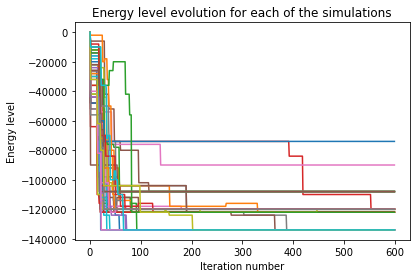

(-133999.78251847686,
 array([-1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1]),
 49)

In [15]:
results_annalysis.plot_energies_evolution(energies[:, :])
results_annalysis.extract_full_solution(states, energies)

In [113]:
speeds = states[:, :, :, 1]
positions = states[:, :, :, 0]
n_cond_init, n_particle,  n_iterration = speeds.shape 
abcisses = np.arange(n_iterration)

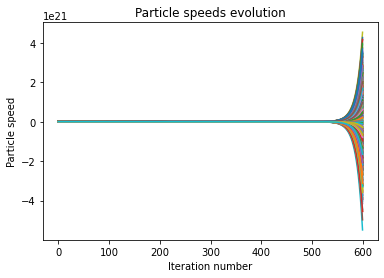

In [111]:
for i in range(n_particle):
    plt.plot(abcisses, speeds[1, i, :])
    plt.xlabel("Iteration number")
    plt.ylabel("Particle speed")
    plt.title("Particle speeds evolution")

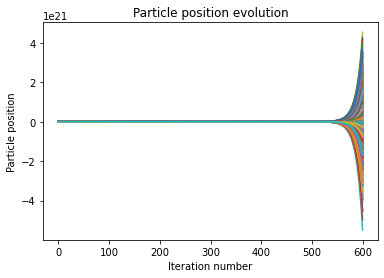

In [114]:
for i in range(n_particle):
    plt.plot(abcisses, positions[1, i, :])
    plt.xlabel("Iteration number")
    plt.ylabel("Particle position")
    plt.title("Particle position evolution")

In [109]:
energy, spins, _ = results_annalysis.extract_full_solution(states, energies)
SB_sol = 0.5*(spins+1)

In [198]:
-2*energy

3824.0

## Simulated Annealing

In [199]:
def calculate_cut_value(adj_matrix, solution):
    cut_value = 0
    for i in range(len(solution)):
        for j in range(len(solution)):
            if solution[i] != solution[j]:
                cut_value += adj_matrix[i][j]
    return cut_value

def simulated_annealing(adj_matrix, time_limit):
    # Initialize with a random solution
    current_solution = np.random.choice([0, 1], size=(adj_matrix.shape[0],))
    best_solution = np.copy(current_solution)
    current_cut_value = calculate_cut_value(adj_matrix, current_solution)
    best_cut_value = current_cut_value
    
    # Parameters for the annealing schedule
    temp = 1.0
    cooling_rate = 0.99
    
    start_time = time.time()
    
    while time.time() - start_time < time_limit:
        # Create a new neighbor solution
        new_solution = np.copy(current_solution)
        # Flip a random bit to create a neighbor solution
        flip_index = random.randint(0, len(new_solution) - 1)
        new_solution[flip_index] = 1 - new_solution[flip_index]
        
        new_cut_value = calculate_cut_value(adj_matrix, new_solution)
        
        # Determine if we should accept the new solution
        if new_cut_value > current_cut_value:
            current_solution = new_solution
            current_cut_value = new_cut_value
            if new_cut_value > best_cut_value:
                best_solution = new_solution
                best_cut_value = new_cut_value
        else:
            # Accept with a certain probability if the new solution is worse
            if random.random() < math.exp((new_cut_value - current_cut_value) / temp):
                current_solution = new_solution
                current_cut_value = new_cut_value
        
        # Decrease the temperature
        temp *= cooling_rate
    
    return best_solution, best_cut_value

In [200]:
def simulated_annealing_max_cut(G, time_limit):
    # Initial random partition
    partition = np.random.choice([0, 1], size=len(G.nodes))
    best_partition = np.copy(partition)
    best_cut_value = nx.cut_size(G, np.where(partition == 0)[0], np.where(partition == 1)[0])

    # Set initial temperature and cooling schedule
    T = 10.0
    T_min = 0.001
    alpha = 0.9

    start_time = time.time()

    while time.time() - start_time < time_limit:
        for i in range(100):  # Perform 100 iterations at each temperature
            # Pick a random node and toggle its part
            node = random.choice(list(G.nodes))
            partition[node] = 1 - partition[node]

            # Calculate the cut value
            current_cut_value = nx.cut_size(G, np.where(partition == 0)[0], np.where(partition == 1)[0])

            # Check if the new partition is better or accepted by the probability
            delta = current_cut_value - best_cut_value
            if delta > 0 or random.random() < np.exp(delta / T):
                if delta > 0:
                    best_cut_value = current_cut_value
                    best_partition = np.copy(partition)
            else:
                # Revert the change
                partition[node] = 1 - partition[node]

        # Cool down the temperature
        T = max(T_min, T * alpha)

    return best_partition, best_cut_value

In [201]:
SA_sol, SA_energy = simulated_annealing_max_cut(nx.DiGraph(graph), 25)

In [202]:
calculate_cut_value(graph, SA_sol), calculate_cut_value(graph, SB_sol)

(6752.0, 6938.0)